# Boilerplate

Package installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [17]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
    (relu): ReLU()
  )
)

In [19]:
for param in model.children():
    print(param)
    if isinstance(param, Net):
        for param1 in param.children():
            print(param1)

Normalize()
Net(
  (fc): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
  (relu): ReLU()
)
Linear(in_features=784, out_features=200, bias=True)
Linear(in_features=200, out_features=10, bias=True)
ReLU()


In [21]:
model[1].fc.bias.shape

torch.Size([200])

# Implement the Attacks

Functions are given a simple useful signature that you can start with. Feel free to extend the signature as you see fit.

You may find it useful to create a 'batched' version of PGD that you can use to create the adversarial attack.

In [2]:
# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, x, y, eps):
    #TODO: implement this as an intermediate step of PGD
    # Notes: put the model in eval() mode for this function
    
    x = x.detach().requires_grad_(True) #need the gradient
    loss = F.cross_entropy(model(x), y)
    loss.backward()
    grad = x.grad.data
    x = x + eps*grad.sign() #untargeted, move to maximize loss
    return x

def pgd_untargeted(model, x, y, k, eps, eps_step):
    #TODO: implement this 
    # Notes: put the model in eval() mode for this function
    model.eval()

    min_x = x - eps
    max_x = x + eps
    for i in range(k):
        x = fgsm(model, x, y, eps_step)
        x = torch.clamp(x, min=min_x, max=max_x)
        # preds = model(x).argmax()
        # if preds != y:
        #     break early?
    return x

# Implement Adversarial Training

In [3]:
data = next(iter(train_loader))
data[0].shape, data[1].shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [4]:
len(train_loader)

938

In [5]:
def train_model(model, num_epochs, enable_defense=True, attack='pgd', eps=0.1):
    # TODO: implement this function that trains a given model on the MNIST dataset.
    # this is a general-purpose function for both standard training and adversarial training.
    # (toggle enable_defense parameter to switch between training schemes)

    loss = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    eps_step = 0.01
    k = 25
    for num_epoch in range(num_epochs):
        epoch_loss = 0
        start_time = time.time()
        for i, batch in enumerate(train_loader):
            x, y = batch
            x, y = x.to(device), y.to(device)
            logits = model(x)
            ce_loss = loss(logits, y)
            epoch_loss += ce_loss.item()
            optimizer.zero_grad()
            ce_loss.backward()
            optimizer.step()

            if enable_defense:
                #adversarial training
                if attack == 'fgsm':
                    x = fgsm(model, x, y, eps) #could also use eps_step here
                elif attack == 'pgd':
                    x = pgd_untargeted(model, x, y, k, eps, eps_step)
                else:
                    raise ValueError(f"Attack {attack} not implemented")

                logits = model(x)
                ce_loss = loss(logits, y)
                epoch_loss += ce_loss.item()
                optimizer.zero_grad()
                ce_loss.backward()
                optimizer.step()
        print(f"Epoch {num_epoch} done, Epoch Loss {epoch_loss}, Time Taken {time.time()-start_time}")
    

In [6]:
def test_model(model, x, y):
    #assumes model is in eval mode, same device x, y, model

    preds = model(x).argmax(dim=1)
    correct += (preds == y).sum().item()
    total += y.size(0)
    return correct, total
def test_model_on_attacks(model, attack='pgd', eps=0.1):
    # TODO: implement this function to test the robust accuracy of the given model
    # use pgd_untargeted() within this function
    model.eval()
    vanilla_correct = 0
    attack_correct = 0
    vanilla_total = 0
    attack_total = 0
    robust_correct = 0
    robust_total = 0
    success_adversaries = []

    k = 25
    eps_step = 0.01
    for i, batch in enumerate(test_loader):
        x, y = batch
        x, y = x.to(device), y.to(device)
        if attack == 'fgsm':
            attack_x = fgsm(model, x, y, eps)
        elif attack == 'pgd':
            attack_x = pgd_untargeted(model, x, y, k, eps, eps_step)
        else:
            raise ValueError(f"Attack {attack} not implemented")

        preds = model(x).argmax(dim=1)
        attack_preds = model(attack_x).argmax(dim=1)

        vanilla_correct += (preds == y).sum().item()
        attack_correct += (attack_preds == y).sum().item()
        robust_correct += ((attack_preds == y)&(preds==y)).sum().item()
        vanilla_total += y.size(0)
        attack_total += y.size(0)
        robust_total += y.size(0)

        adversaries = ((attack_preds != y)&(preds==y)).nonzero().squeeze()
        if len(adversaries.shape) > 0:
            success_adversaries.extend([(attack_x[i].detach().cpu(), attack_preds[i].detach().cpu(), x[i].detach().cpu(), y[i].detach().cpu()) for i in adversaries])
    print(f"Testing Vanilla Accuracy: {vanilla_correct/vanilla_total}")
    print(f"Testing Attack Accuracy: {attack_correct/attack_total}")
    print(f"Testing Robust Accuracy: {robust_correct/robust_total}")
    return success_adversaries

In [7]:
t1 = torch.tensor([0]).nonzero().squeeze()
t1.shape[0]

0

In [8]:
def plot_adversaries(adversaries, plot_title="Adversaries"):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    for i in range(5):
        axs[0, i].imshow(adversaries[i][0].numpy().reshape(28, 28), cmap='gray')
        axs[0, i].set_title(f"Adversarial Predicted Label: {adversaries[i][1]}")
        axs[1, i].imshow(adversaries[i][2].numpy().reshape(28, 28), cmap='gray')
        axs[1, i].set_title(f"Correct Predicted Label: {adversaries[i][3]}")
    axs[0, 0].set_ylabel("Adversarial Examples")
    axs[1, 0].set_ylabel("Vanilla Examples")
    plt.suptitle(plot_title)
    plt.show()

# Study Accuracy, Quality, etc.

Compare the various results and report your observations on the submission.

In [9]:
## train the original model
model = nn.Sequential(Normalize(), Net())
model = model.to(device)
model.train()

train_model(model, 20, False)
torch.save(model.state_dict(), 'weights.pt')

Epoch 0 done, Epoch Loss 224.45583783090115, Time Taken 9.494938135147095
Epoch 1 done, Epoch Loss 94.67682783678174, Time Taken 8.530589580535889
Epoch 2 done, Epoch Loss 65.09380189236253, Time Taken 7.34524941444397
Epoch 3 done, Epoch Loss 48.73087836464401, Time Taken 7.9042744636535645
Epoch 4 done, Epoch Loss 37.92203506024089, Time Taken 8.479641437530518
Epoch 5 done, Epoch Loss 28.63358599966159, Time Taken 7.1879637241363525
Epoch 6 done, Epoch Loss 26.469985005503986, Time Taken 8.316332578659058
Epoch 7 done, Epoch Loss 20.717404623195762, Time Taken 8.442991018295288
Epoch 8 done, Epoch Loss 16.866417320386972, Time Taken 6.824644088745117
Epoch 9 done, Epoch Loss 17.975984879805765, Time Taken 8.921849489212036
Epoch 10 done, Epoch Loss 13.716466598969419, Time Taken 9.011977195739746
Epoch 11 done, Epoch Loss 12.065855054788699, Time Taken 6.447911500930786
Epoch 12 done, Epoch Loss 13.307051355996009, Time Taken 7.935093641281128
Epoch 13 done, Epoch Loss 12.1776179607

Testing Vanilla Accuracy: 0.9813
Testing Attack Accuracy: 0.3536
Testing Robust Accuracy: 0.3536


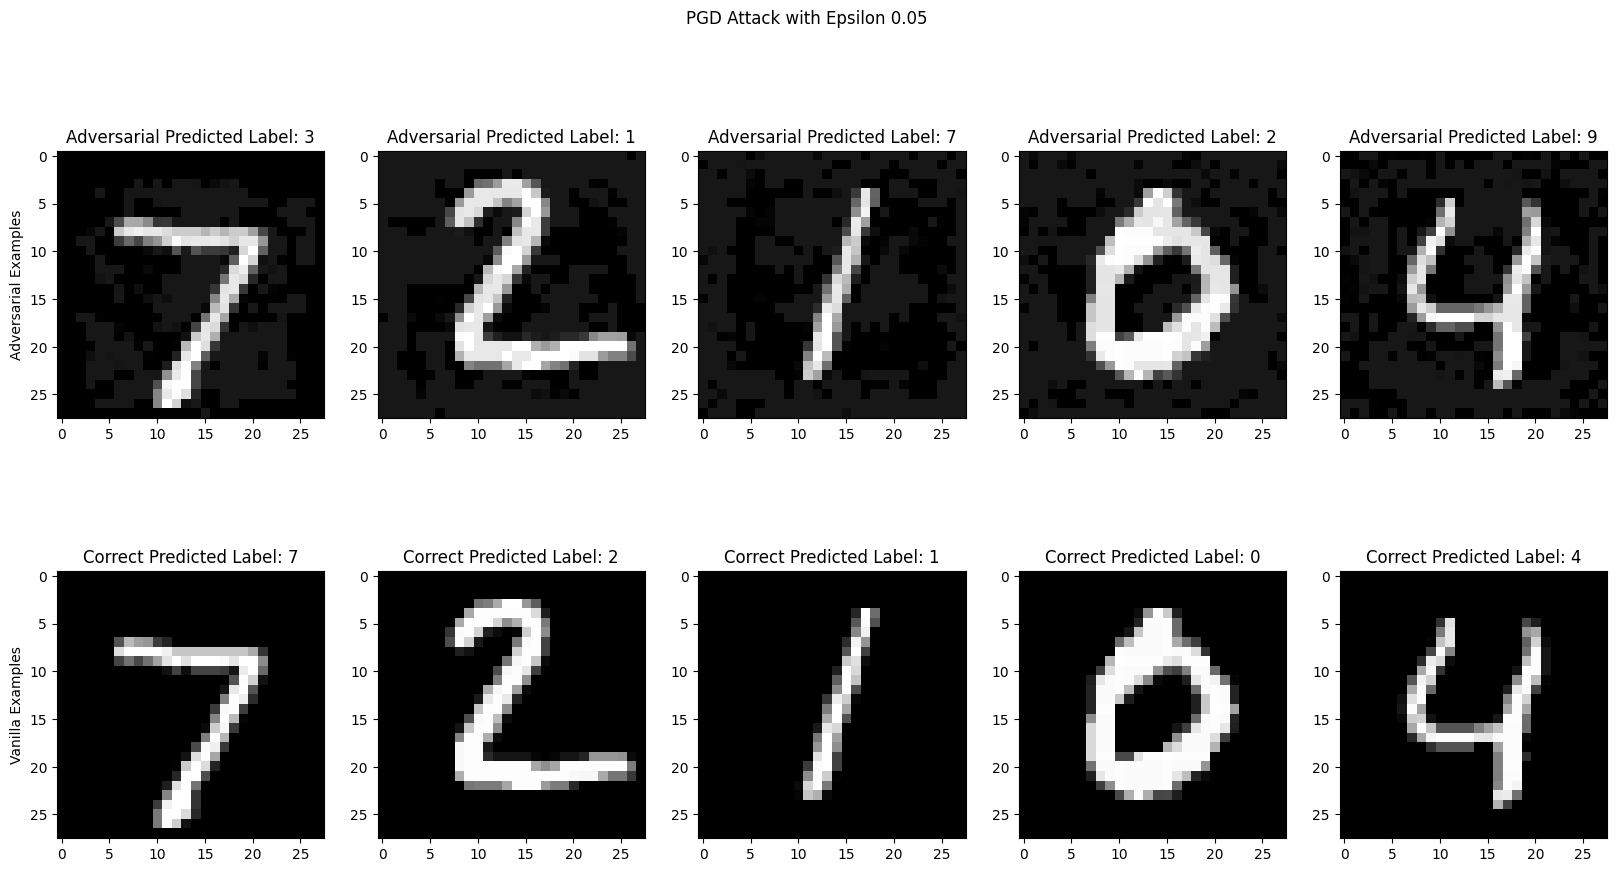

Testing Vanilla Accuracy: 0.9813
Testing Attack Accuracy: 0.0279
Testing Robust Accuracy: 0.0279


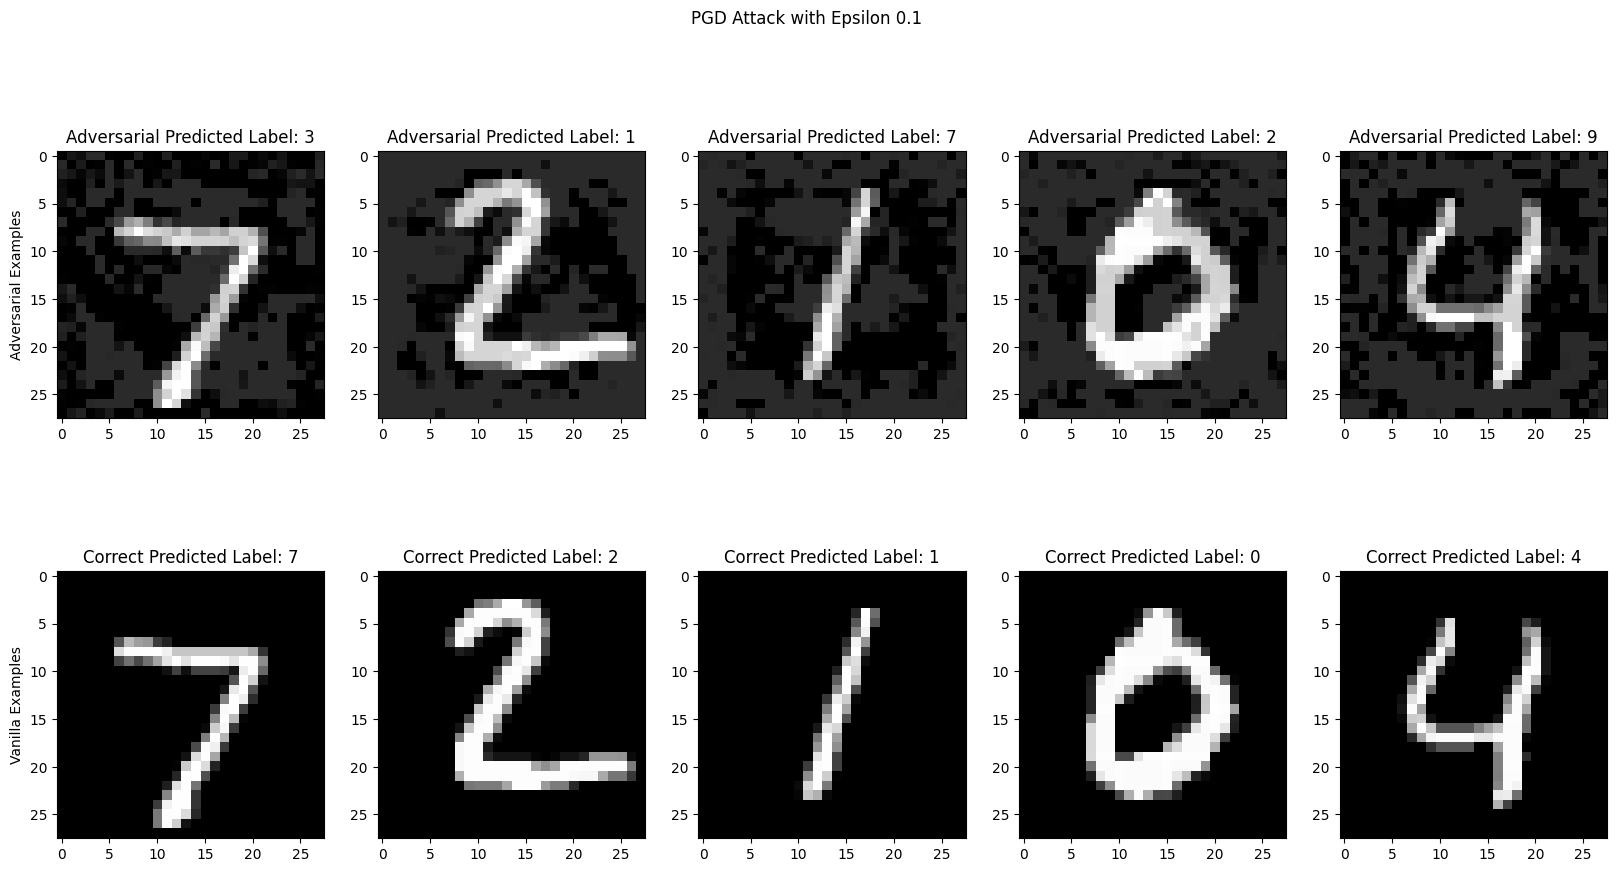

Testing Vanilla Accuracy: 0.9813
Testing Attack Accuracy: 0.0057
Testing Robust Accuracy: 0.0057


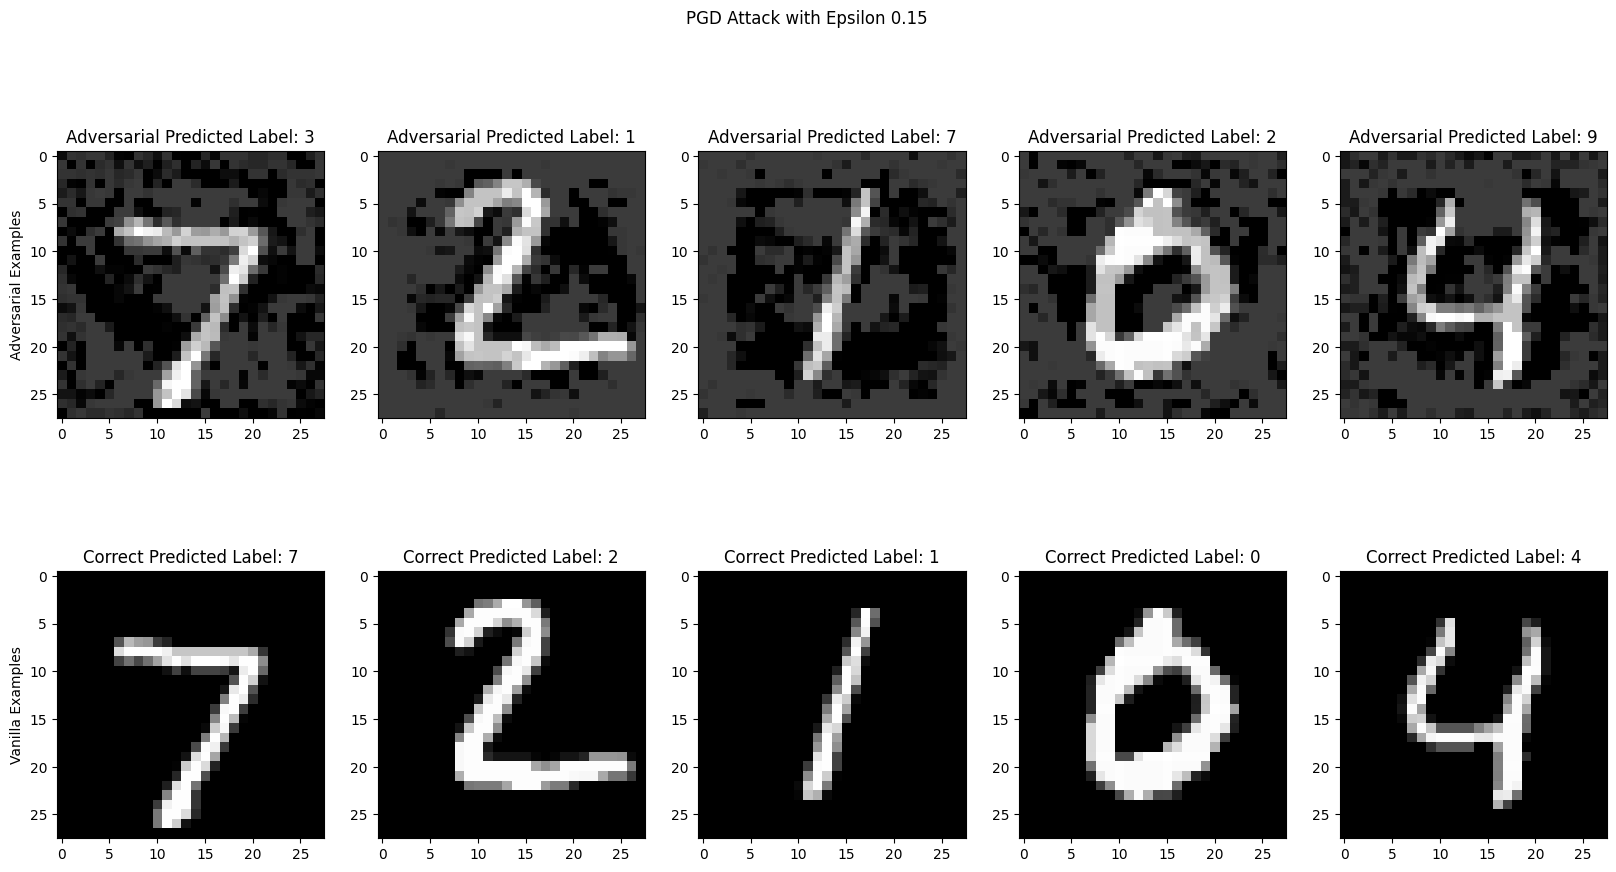

Testing Vanilla Accuracy: 0.9813
Testing Attack Accuracy: 0.0022
Testing Robust Accuracy: 0.0022


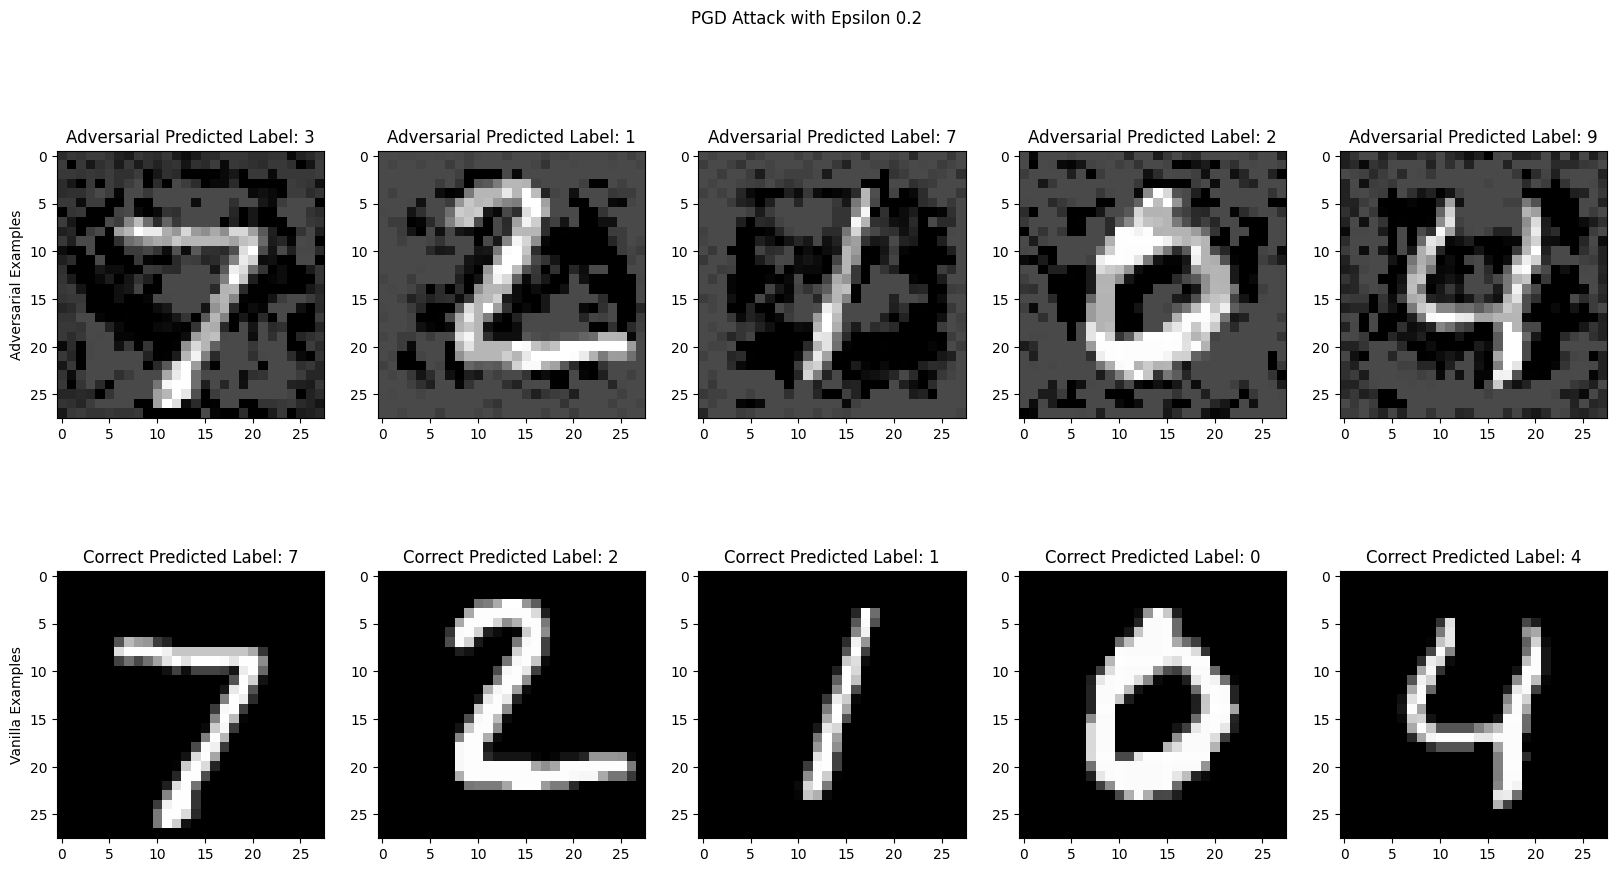

In [11]:
## PGD attack
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    adversaries = test_model_on_attacks(model, attack='pgd', eps=eps)
    plot_adversaries(adversaries, plot_title=f"PGD Attack with Epsilon {eps}")

In [12]:
## PGD based adversarial training
model = nn.Sequential(Normalize(), Net())
eps = 0.1
train_model(model, 20, True, 'pgd', eps)
torch.save(model.state_dict(), f'weights_AT_{eps}.pt')

Epoch 0 done, Epoch Loss 1216.5877036079764, Time Taken 56.801311016082764
Epoch 1 done, Epoch Loss 810.8782961461693, Time Taken 44.015841245651245
Epoch 2 done, Epoch Loss 742.1147850519046, Time Taken 44.233710289001465
Epoch 3 done, Epoch Loss 697.8163384636864, Time Taken 47.92696142196655
Epoch 4 done, Epoch Loss 669.8340283036232, Time Taken 50.77714490890503
Epoch 5 done, Epoch Loss 648.3080906281248, Time Taken 47.51552987098694
Epoch 6 done, Epoch Loss 632.2910931520164, Time Taken 49.97602200508118
Epoch 7 done, Epoch Loss 624.051210203208, Time Taken 62.65474605560303
Epoch 8 done, Epoch Loss 611.5140186082572, Time Taken 51.15284490585327
Epoch 9 done, Epoch Loss 605.4197590597905, Time Taken 47.58243536949158
Epoch 10 done, Epoch Loss 601.2166489874944, Time Taken 46.01028084754944
Epoch 11 done, Epoch Loss 596.3196212900802, Time Taken 45.85642647743225
Epoch 12 done, Epoch Loss 593.0272506172769, Time Taken 47.31099510192871
Epoch 13 done, Epoch Loss 587.7782725337893, 

Testing Vanilla Accuracy: 0.9786
Testing Attack Accuracy: 0.9339
Testing Robust Accuracy: 0.9339


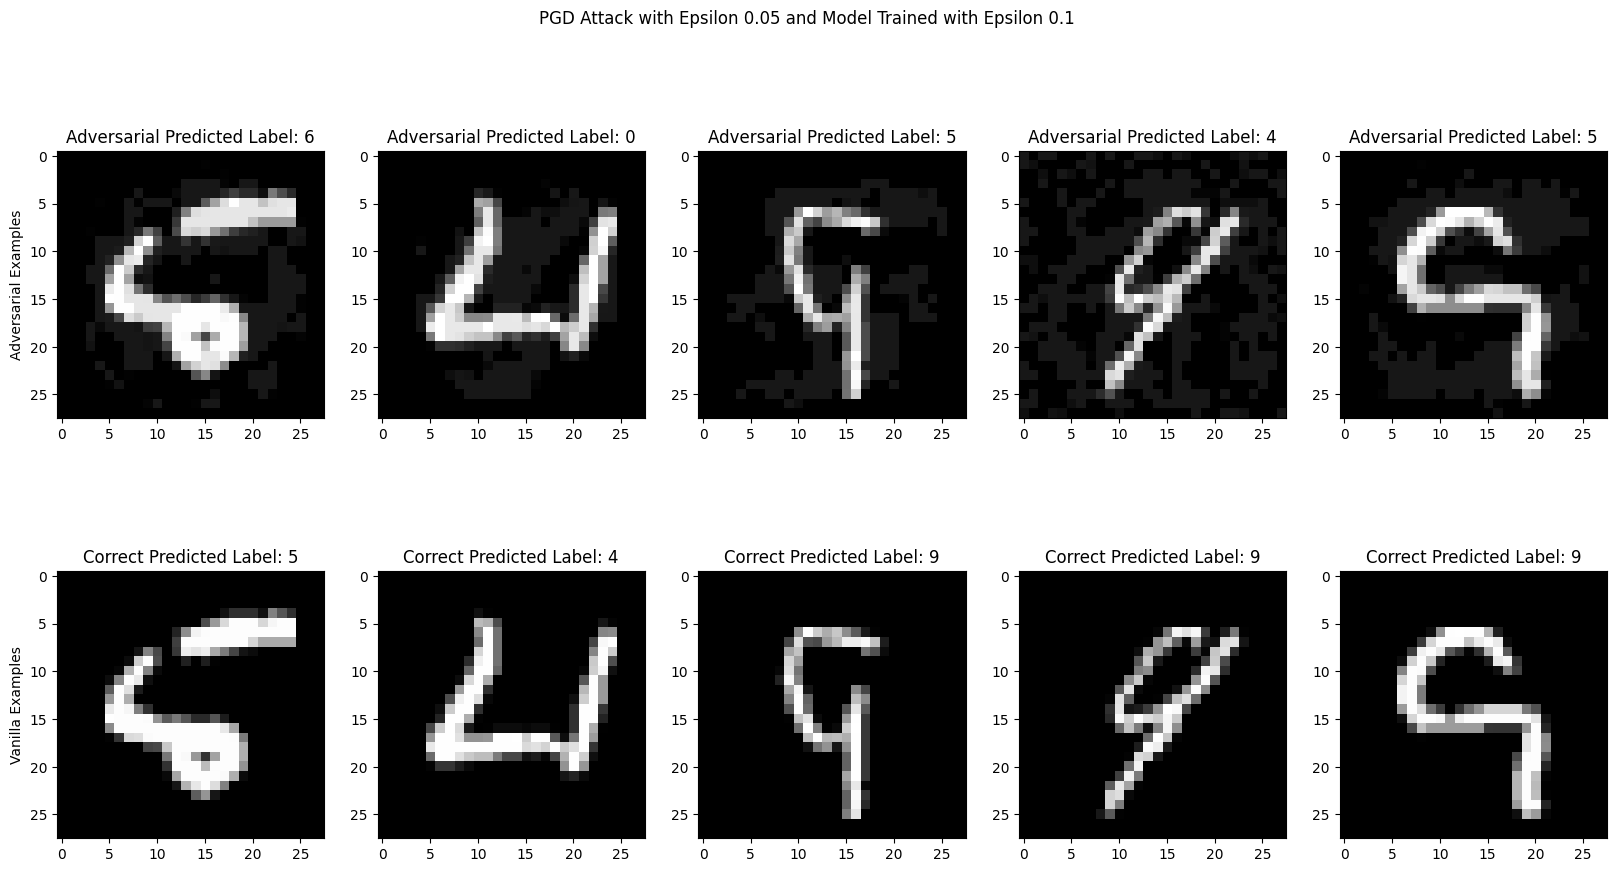

Testing Vanilla Accuracy: 0.9786
Testing Attack Accuracy: 0.8216
Testing Robust Accuracy: 0.8216


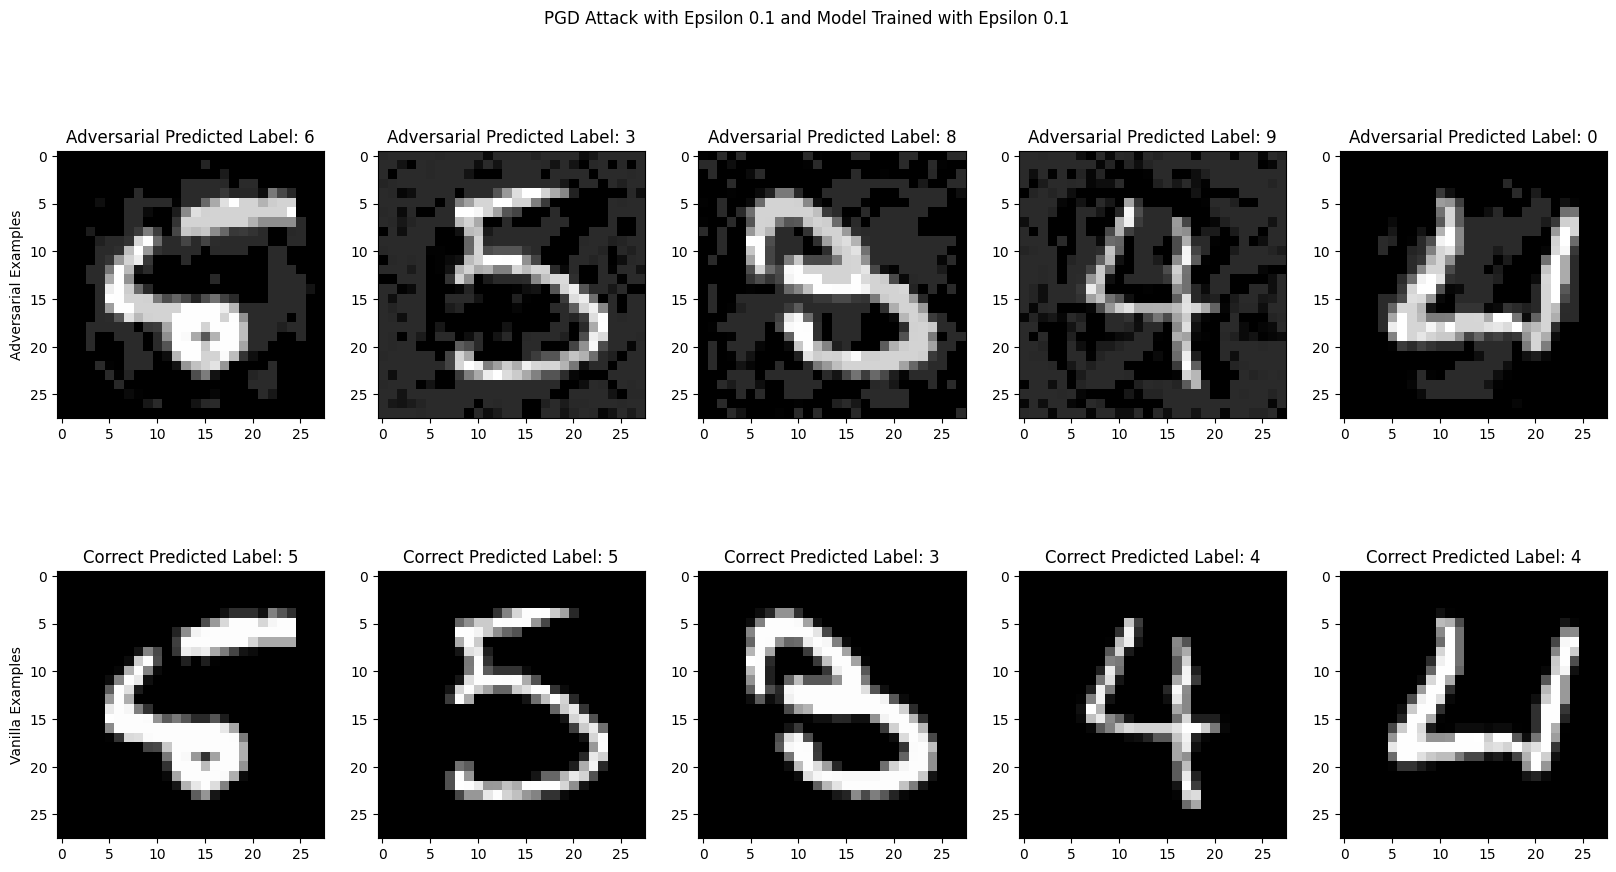

Testing Vanilla Accuracy: 0.9786
Testing Attack Accuracy: 0.6037
Testing Robust Accuracy: 0.6037


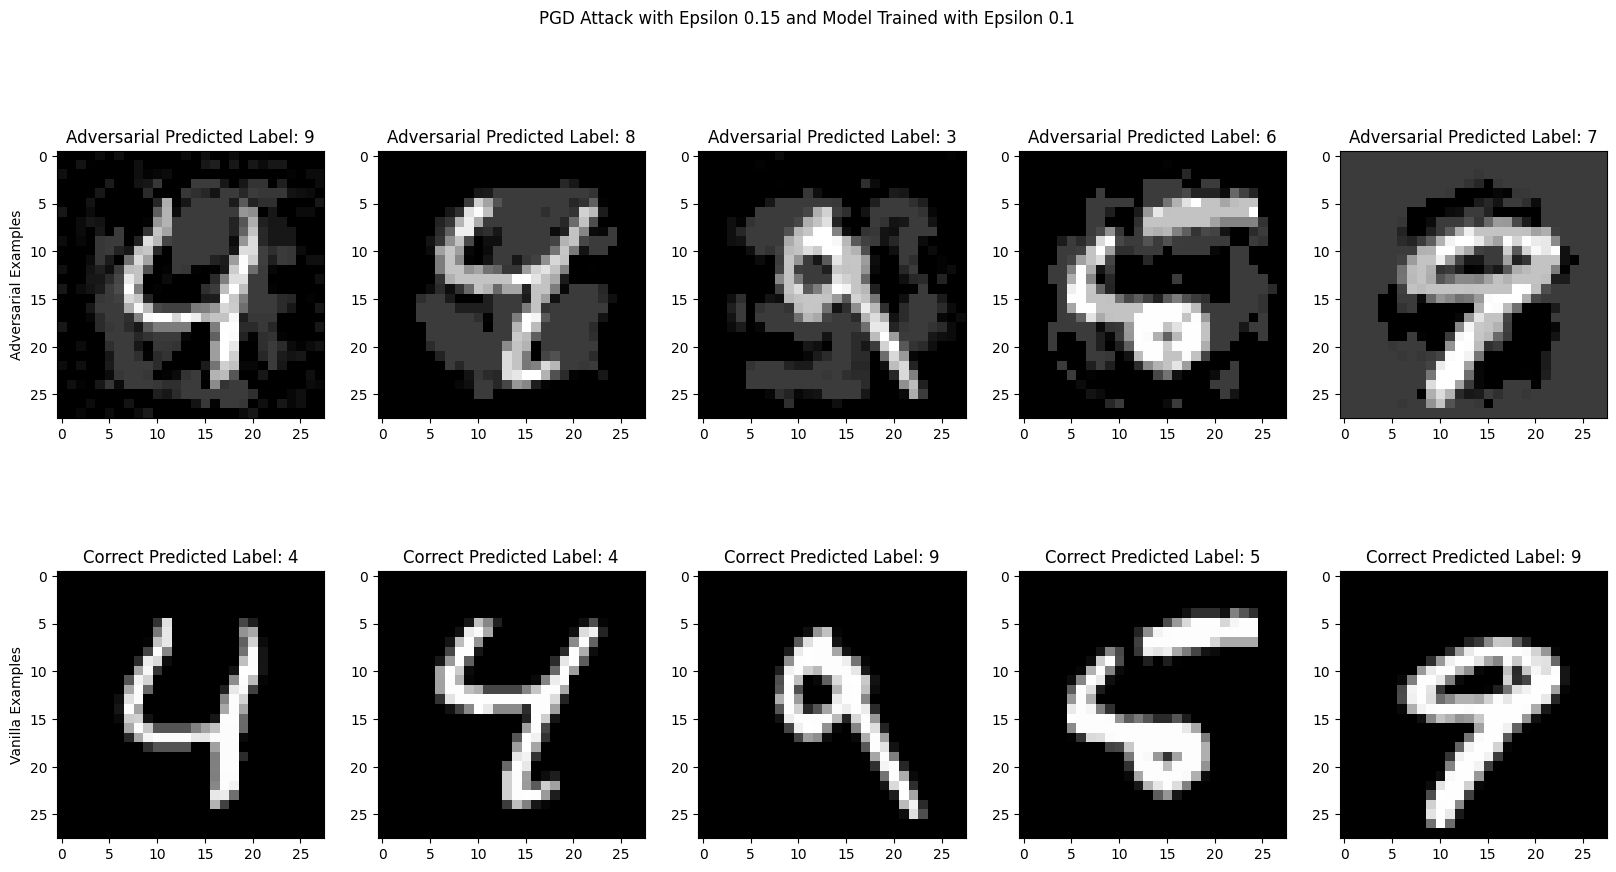

Testing Vanilla Accuracy: 0.9786
Testing Attack Accuracy: 0.3017
Testing Robust Accuracy: 0.3017


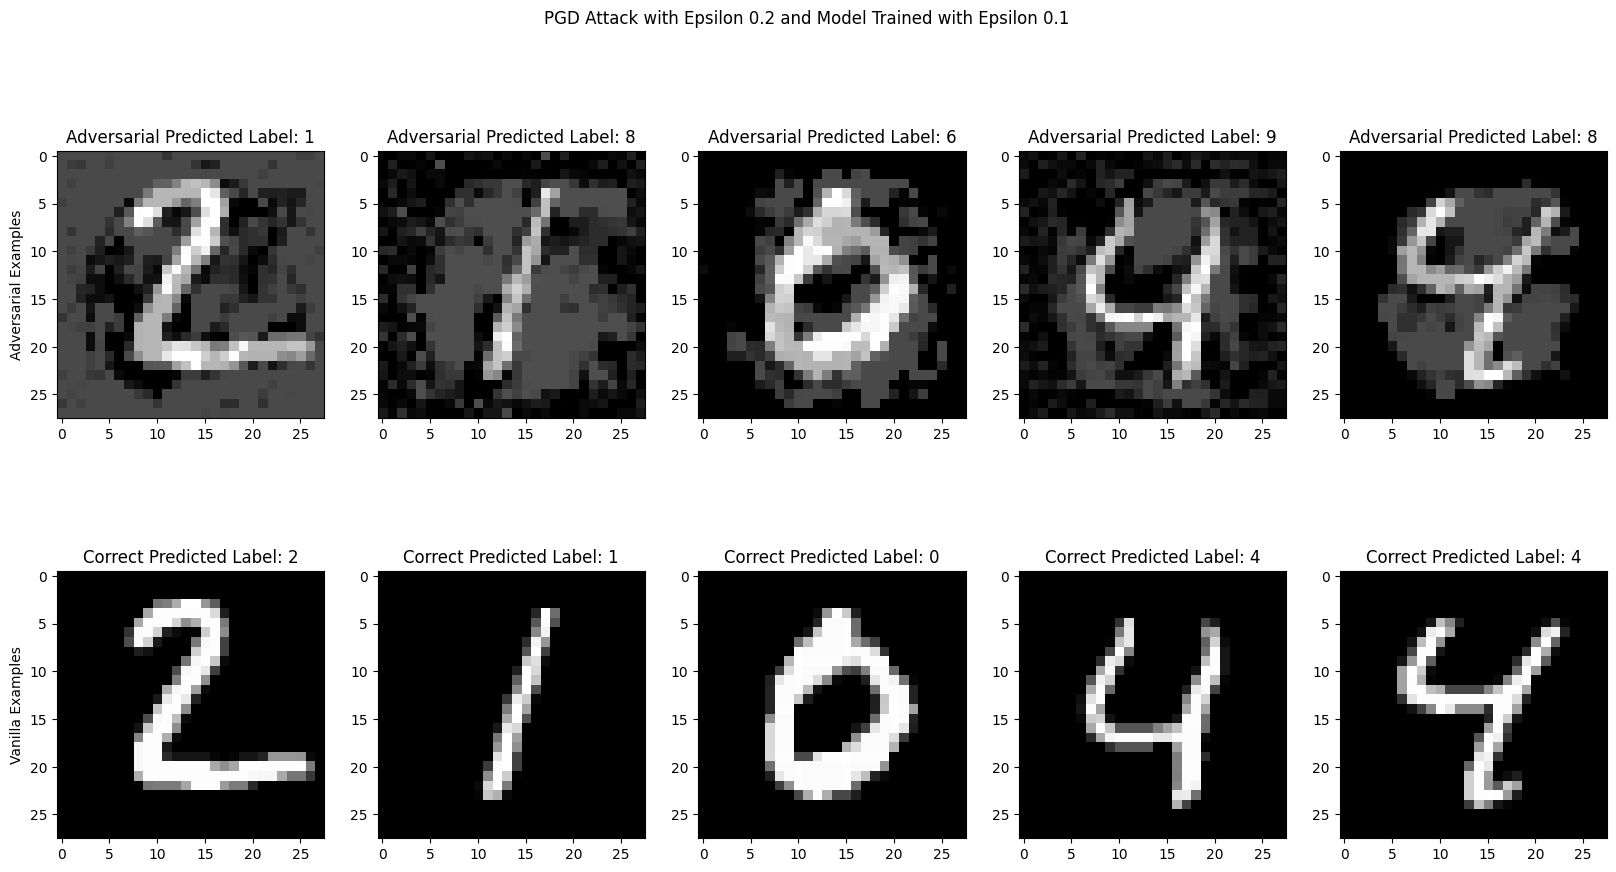

In [13]:
import os
model = nn.Sequential(Normalize(), Net())

eps_model=0.1
model.load_state_dict(torch.load(f'weights_AT_{eps_model}.pt'))
for eps in [0.05, 0.1, 0.15, 0.2]:
    
    adversaries = test_model_on_attacks(model, attack='pgd', eps=eps)
    if len(adversaries) > 5:
        plot_adversaries(adversaries, plot_title=f"PGD Attack with Epsilon {eps} and Model Trained with Epsilon {eps_model}")
    else:
        print(f"Less than 5, only {len(adversaries)} Adversaries found for Epsilon {eps} and Model Trained with Epsilon {eps_model}")

Testing Vanilla Accuracy: 0.9813
Testing Attack Accuracy: 0.5532
Testing Robust Accuracy: 0.5532


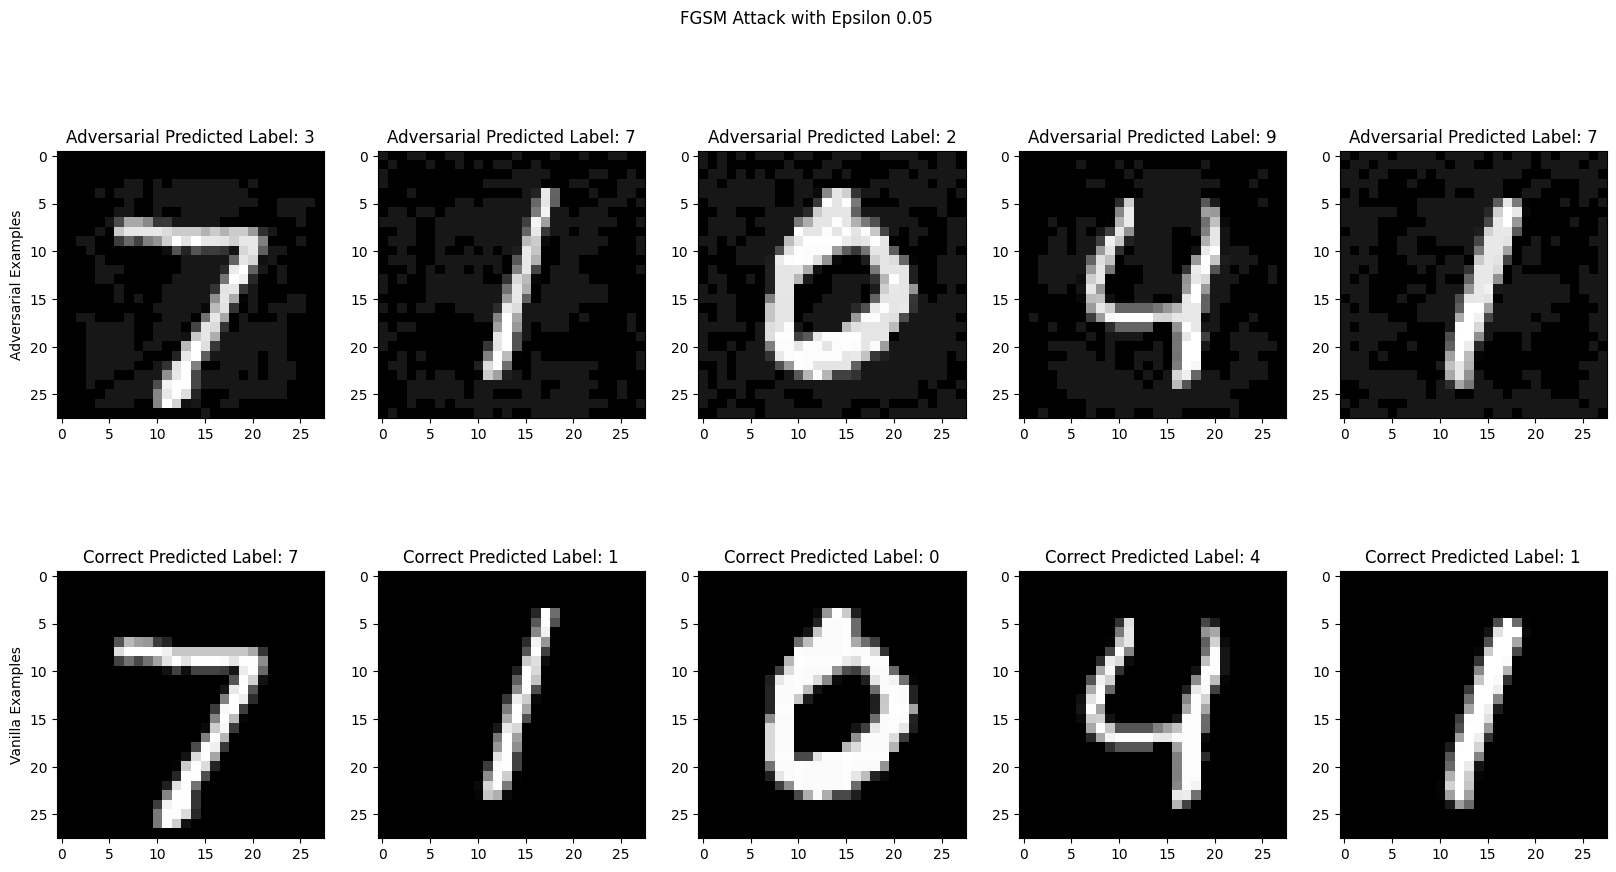

Testing Vanilla Accuracy: 0.9813
Testing Attack Accuracy: 0.2505
Testing Robust Accuracy: 0.2505


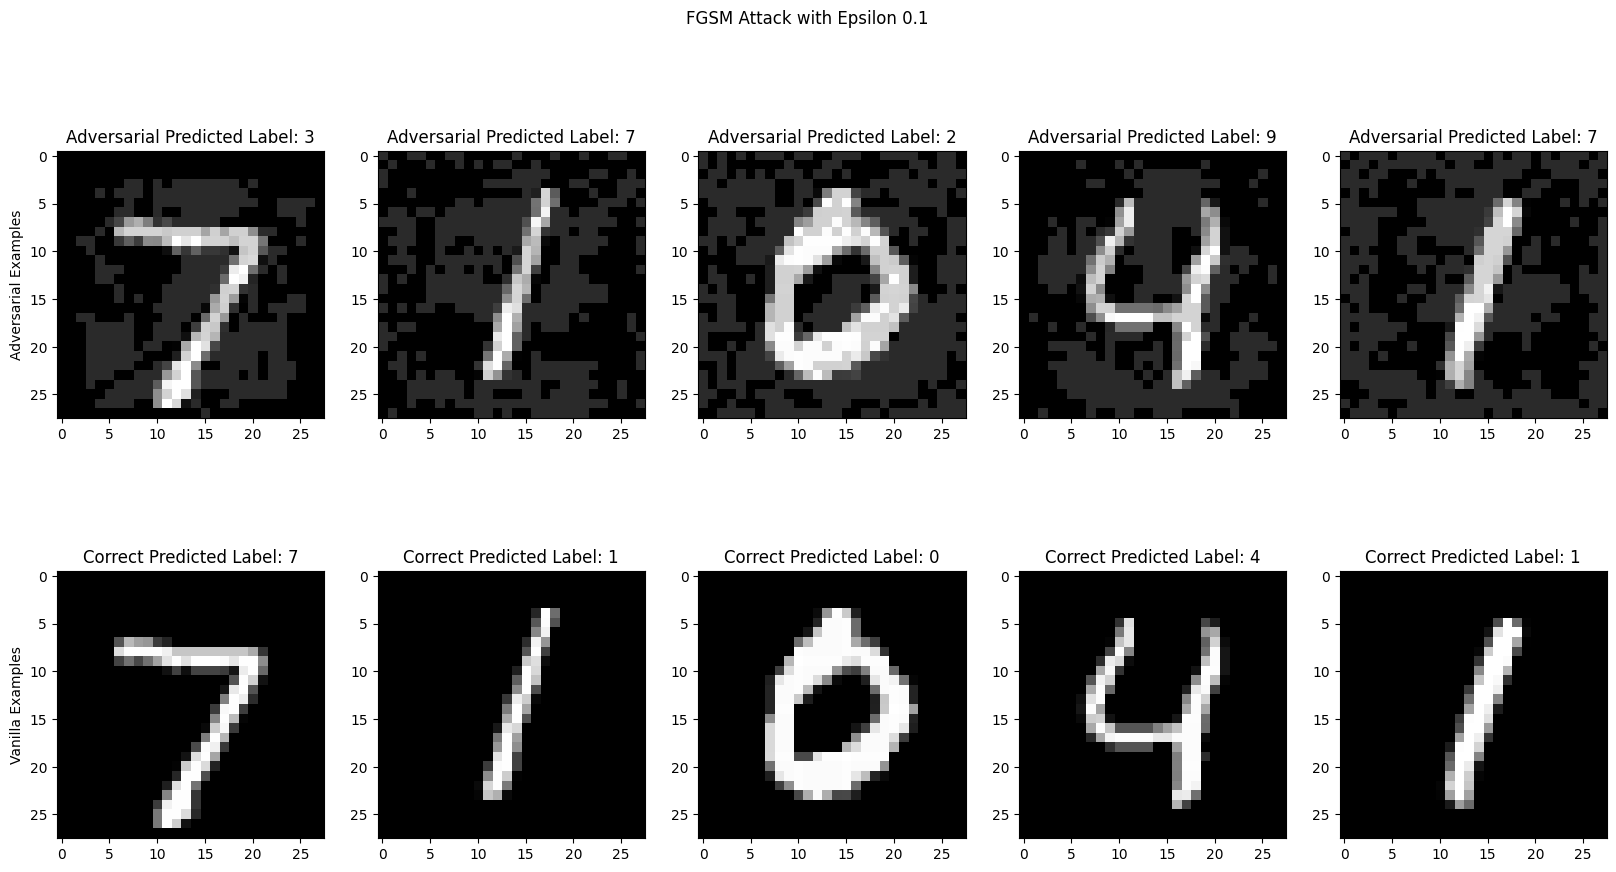

Testing Vanilla Accuracy: 0.9813
Testing Attack Accuracy: 0.1236
Testing Robust Accuracy: 0.1236


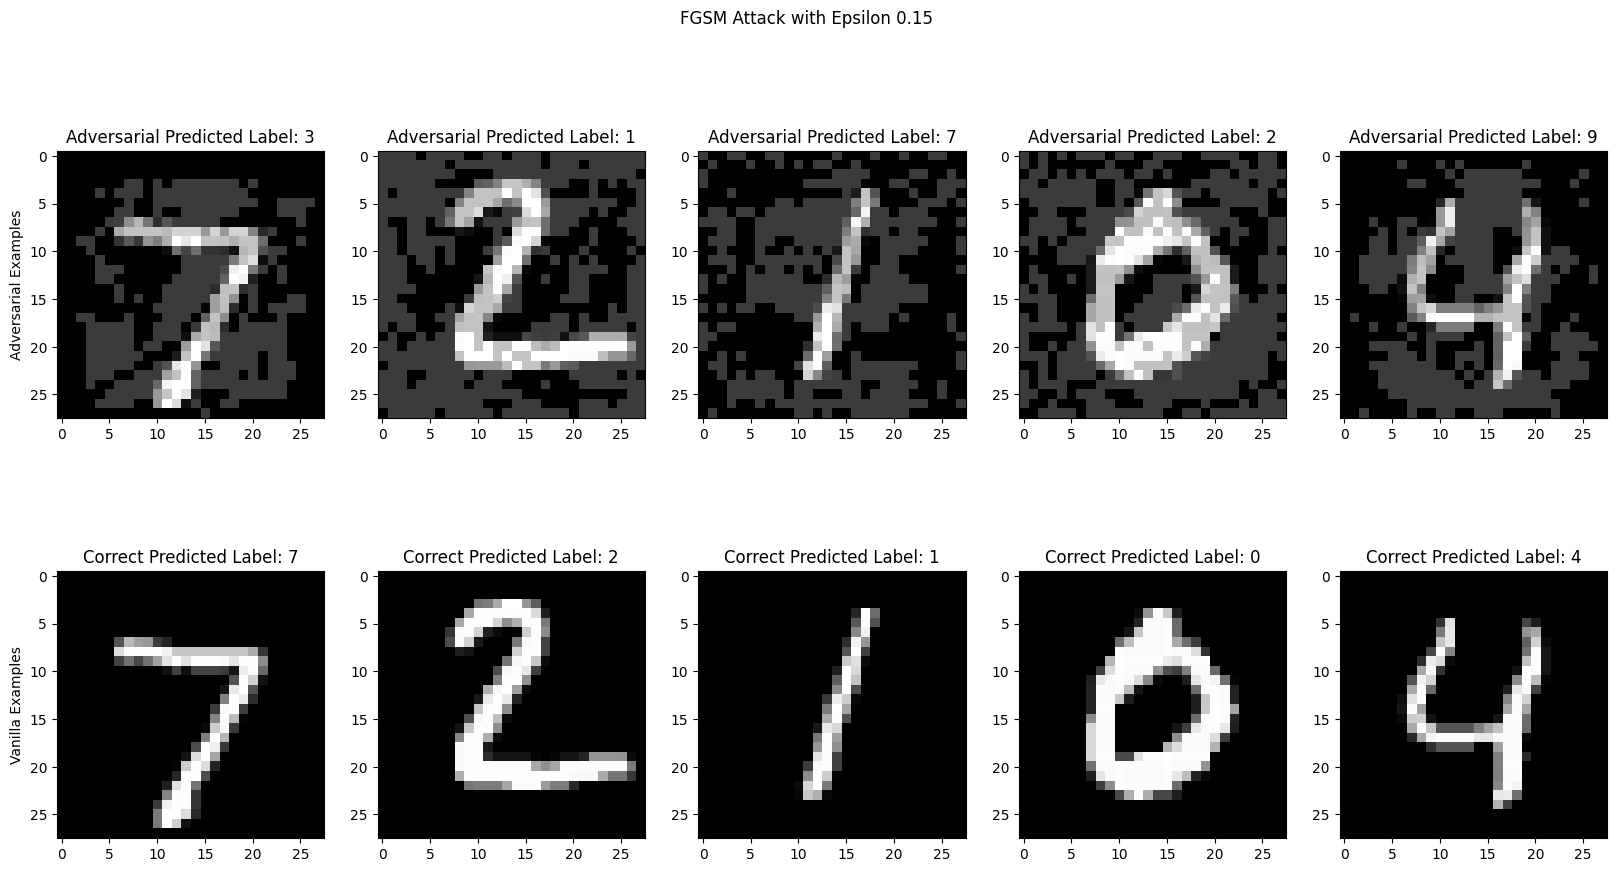

Testing Vanilla Accuracy: 0.9813
Testing Attack Accuracy: 0.0677
Testing Robust Accuracy: 0.0677


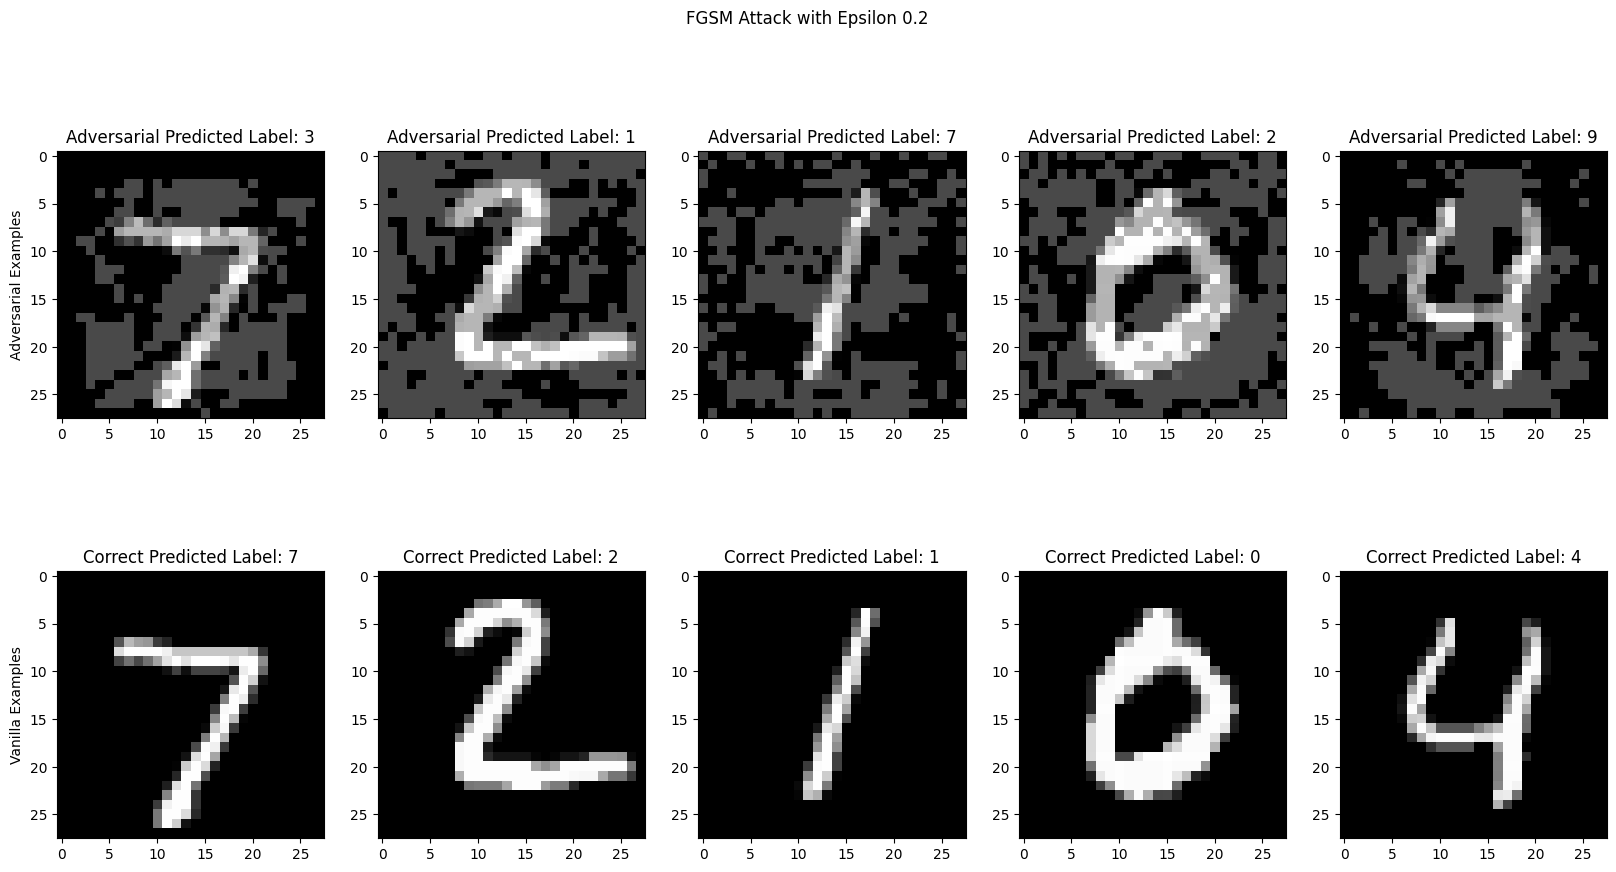

In [15]:
## FGSM attack
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    adversaries = test_model_on_attacks(model, attack='fgsm', eps=eps)
    plot_adversaries(adversaries, plot_title=f"FGSM Attack with Epsilon {eps}")

Testing Vanilla Accuracy: 0.9786
Testing Attack Accuracy: 0.9365
Testing Robust Accuracy: 0.9365


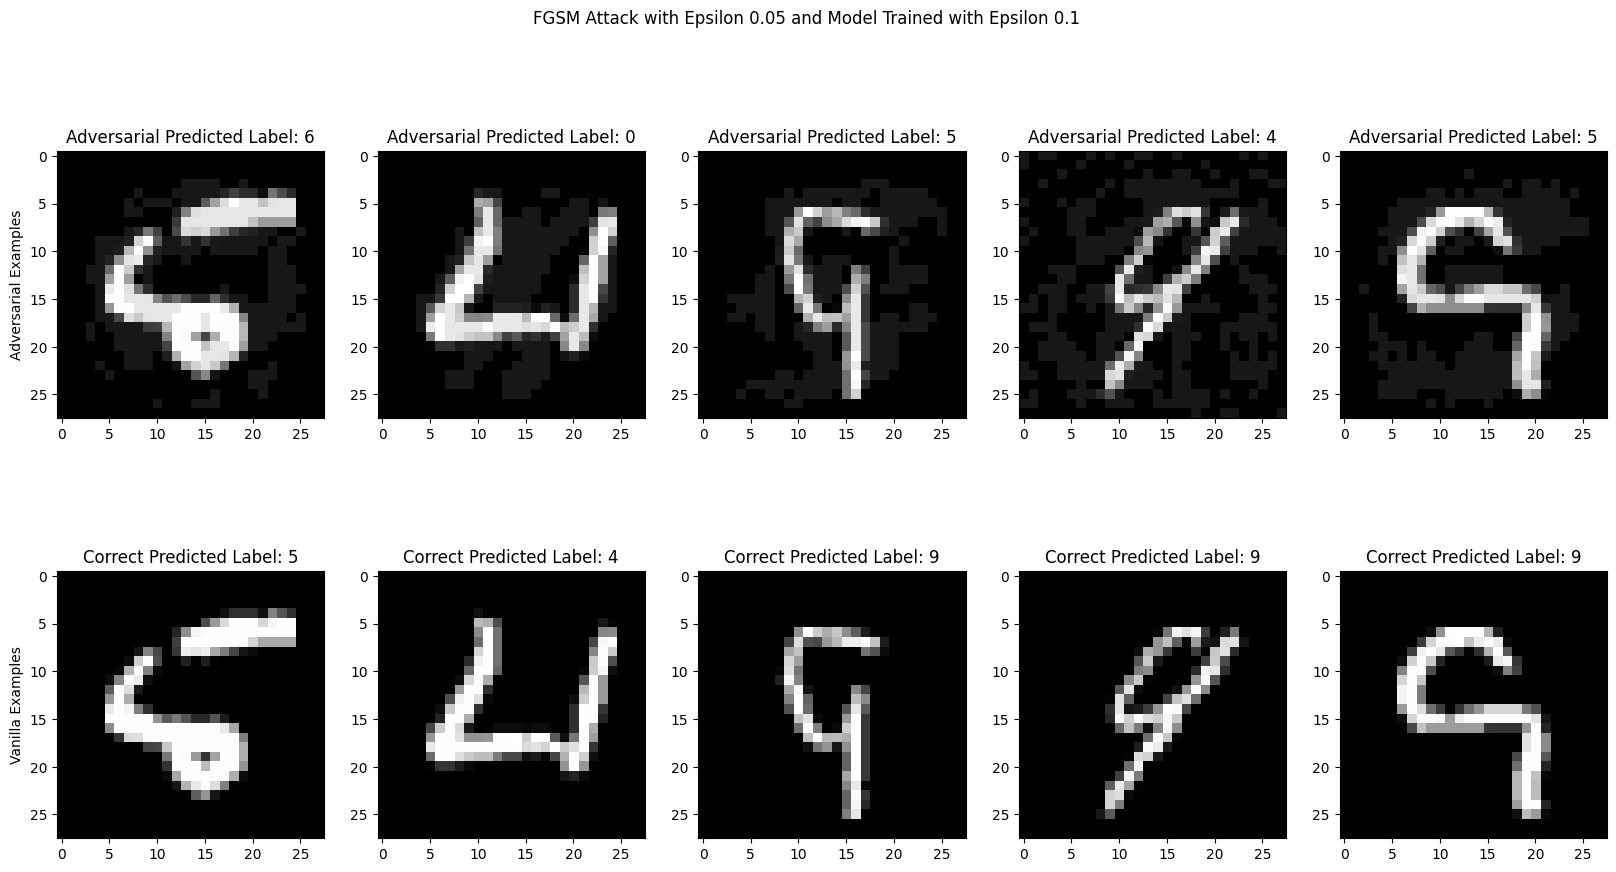

Testing Vanilla Accuracy: 0.9786
Testing Attack Accuracy: 0.8555
Testing Robust Accuracy: 0.8555


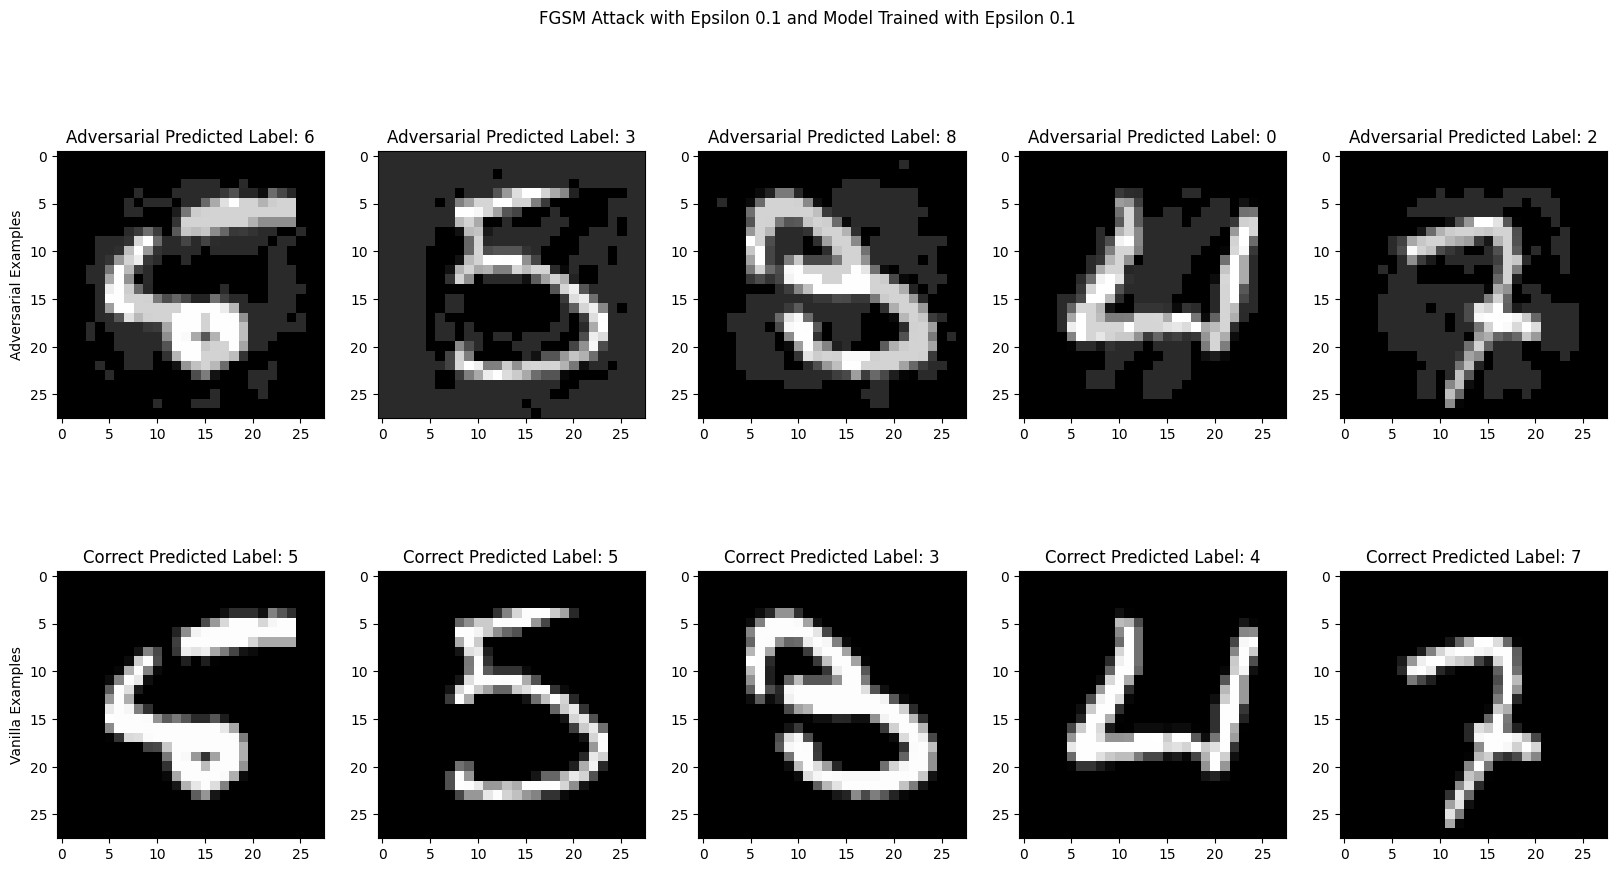

Testing Vanilla Accuracy: 0.9786
Testing Attack Accuracy: 0.7127
Testing Robust Accuracy: 0.7127


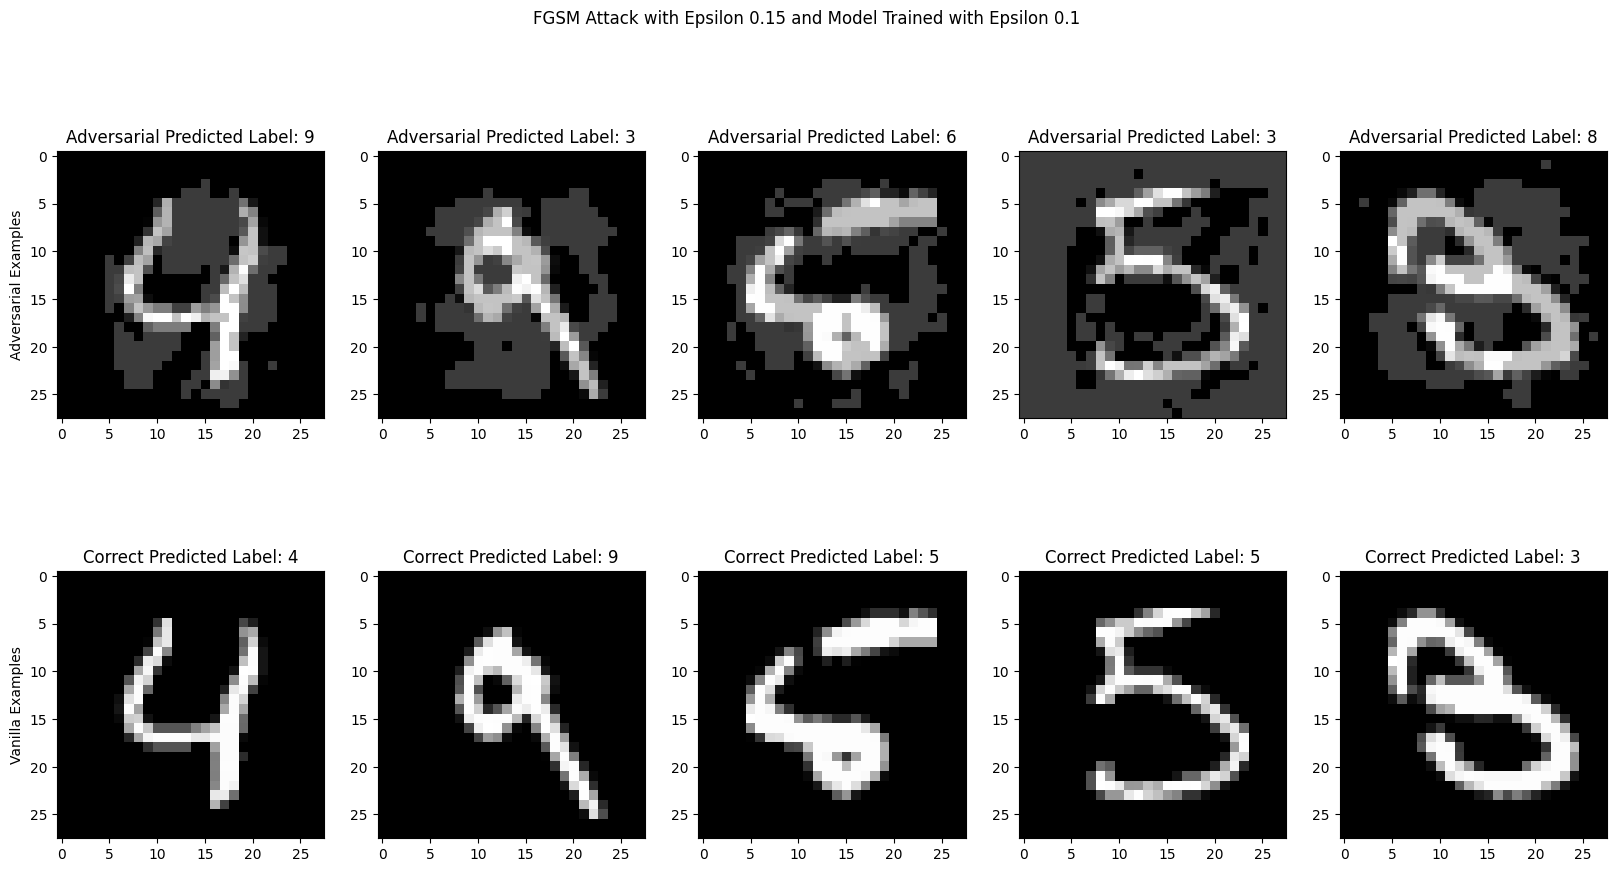

Testing Vanilla Accuracy: 0.9786
Testing Attack Accuracy: 0.5004
Testing Robust Accuracy: 0.5004


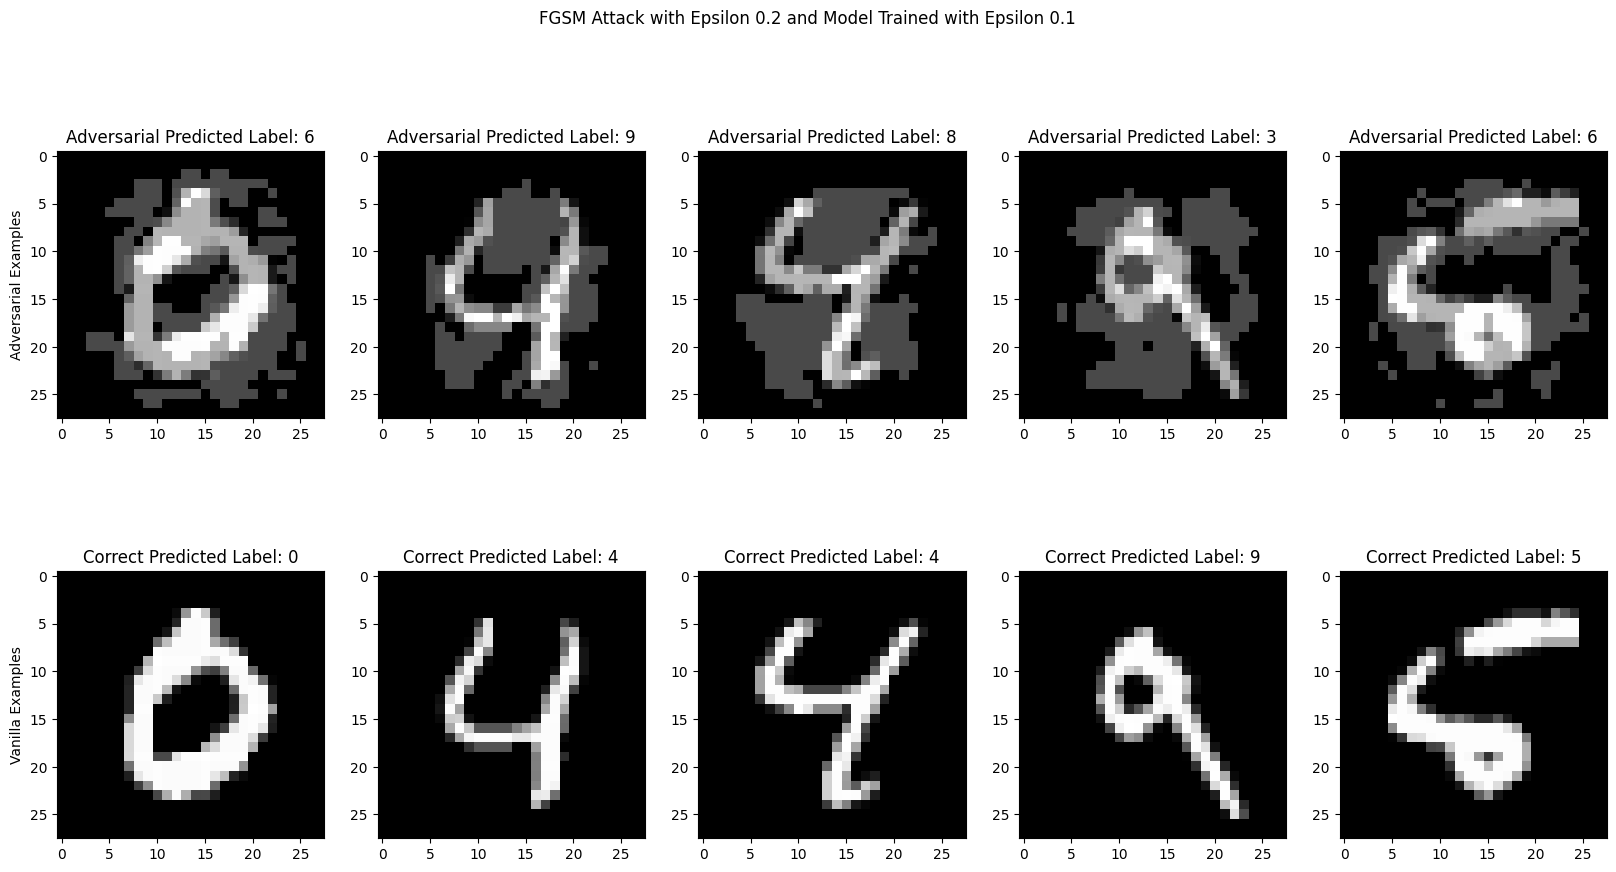

In [14]:
import os
model = nn.Sequential(Normalize(), Net())

eps_model=0.1
model.load_state_dict(torch.load(f'weights_AT_{eps_model}.pt'))
for eps in [0.05, 0.1, 0.15, 0.2]:
    
    adversaries = test_model_on_attacks(model, attack='fgsm', eps=eps)
    if len(adversaries) > 5:
        plot_adversaries(adversaries, plot_title=f"FGSM Attack with Epsilon {eps} and Model Trained with Epsilon {eps_model}")
    else:
        print(f"Less than 5, only {len(adversaries)} Adversaries found for Epsilon {eps} and Model Trained with Epsilon {eps_model}")